## AMLT ITMO 2023
### Task #2
1. Select the dataset and the ML problem (it is possible to select your old tasks from ML course or other courses implying ML/DL models).
2. Train the model.
3. Analyze the feature importance in your data for making predictions by your model using eli5/SHAP/LIME frameworks: 

- https://eli5.readthedocs.io/en/latest/overview.html#installation
- https://github.com/slundberg/shap
- https://github.com/marcotcr/lime

Calculate permutation importance, SHAP values (for a specific prediction, for data sampling), analyze predictions with LIME; plot PDPs and other visualizations you like.

4. Analyze all the graphs/tables and write conclusions about your data, model and features.
5. Complete a task in a single Jupyter Notebook.

## 1. Select dataset

Classic Iris dataset

In [108]:
import seaborn as sns

import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

%matplotlib inline

In [109]:
from sklearn.datasets import load_iris
import pandas as pd

def load_new_data():
    iris = load_iris()
    df= pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])

    df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)
    return df

df = load_new_data()
print(df.head())

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target species  
0     0.0  setosa  
1     0.0  setosa  
2     0.0  setosa  
3     0.0  setosa  
4     0.0  setosa  


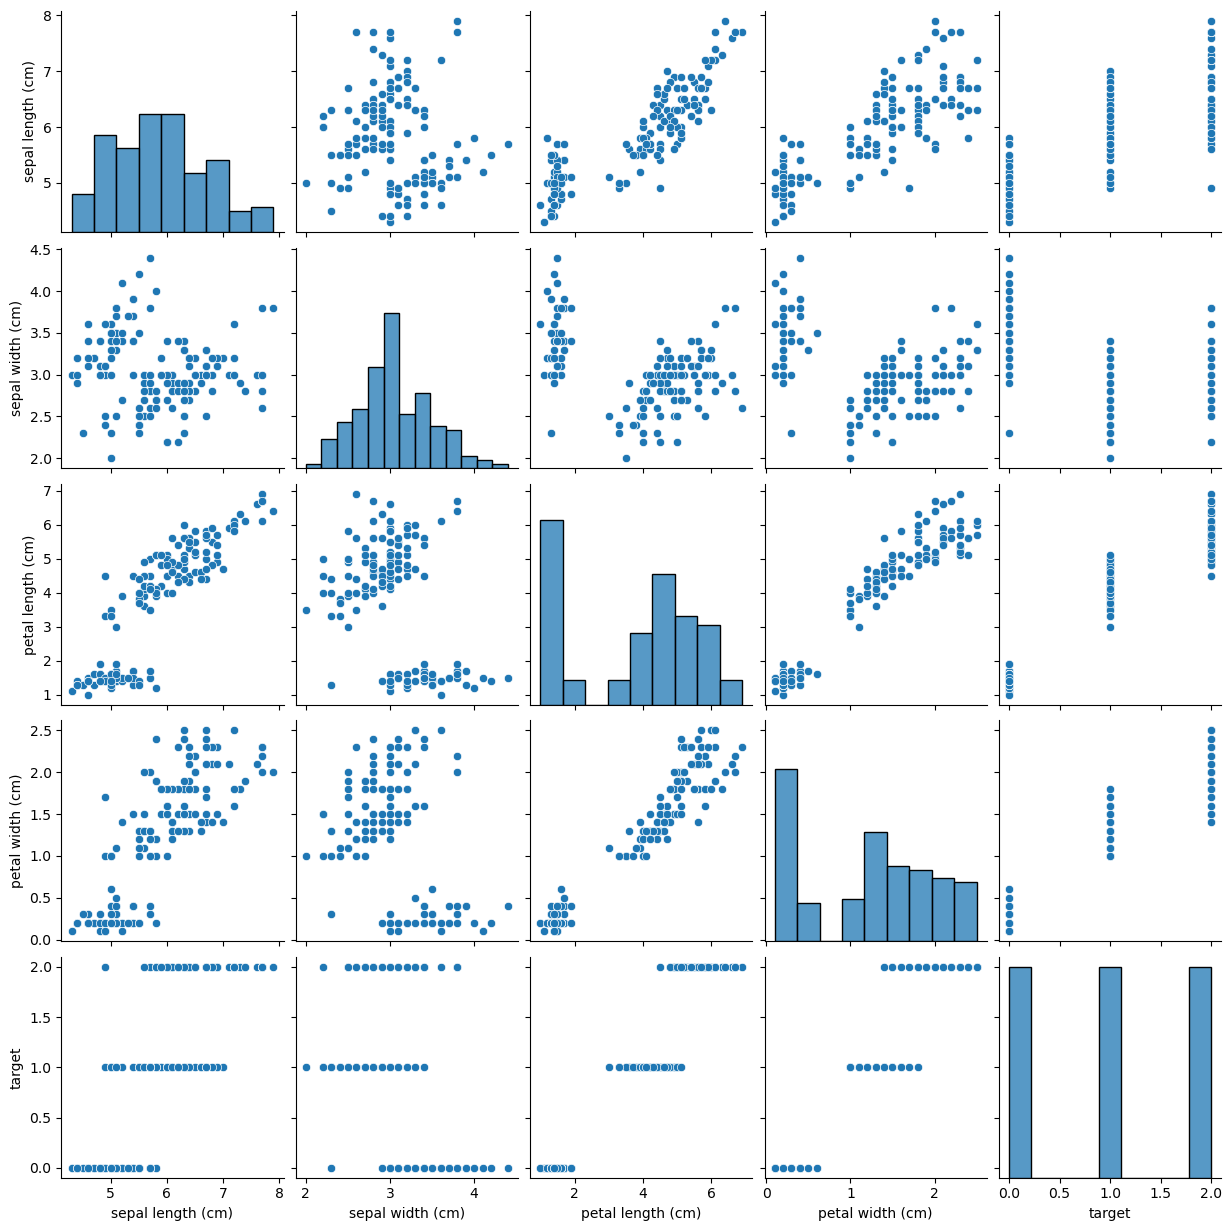

In [234]:
sns.pairplot(df)

## 2. Train Classifier

In [110]:
from catboost import CatBoostClassifier, Pool

df = load_new_data()
X_tr, X_eval = train_test_split(df)

y_tr = X_tr.species
y_tr_clean = y_tr
X_tr.drop(columns=['species', 'target'], inplace=True)
y_eval =  X_eval.species
y_eval_clean = y_eval
X_eval = X_eval.drop(columns=['species', 'target'])


train_dataset = Pool(X_tr, y_tr_clean, feature_names=list(X_tr.columns))

model_params = {
    'iterations': 20, 
    'loss_function': 'MultiClass',
    'train_dir': 'crossentropy',
    'allow_writing_files': False,
    'random_seed': 42,
}

model = CatBoostClassifier(**model_params)
model.fit(train_dataset)

Learning rate set to 0.5
0:	learn: 0.6624861	total: 1.84ms	remaining: 35.1ms
1:	learn: 0.4373888	total: 2.08ms	remaining: 18.7ms
2:	learn: 0.2848559	total: 2.41ms	remaining: 13.7ms
3:	learn: 0.2106337	total: 2.85ms	remaining: 11.4ms
4:	learn: 0.1632913	total: 3.41ms	remaining: 10.2ms
5:	learn: 0.1314857	total: 3.88ms	remaining: 9.05ms
6:	learn: 0.1048972	total: 4.15ms	remaining: 7.7ms
7:	learn: 0.0944243	total: 4.39ms	remaining: 6.59ms
8:	learn: 0.0796607	total: 4.75ms	remaining: 5.8ms
9:	learn: 0.0705950	total: 5.14ms	remaining: 5.14ms
10:	learn: 0.0653720	total: 5.45ms	remaining: 4.46ms
11:	learn: 0.0590116	total: 5.79ms	remaining: 3.86ms
12:	learn: 0.0521522	total: 6.04ms	remaining: 3.25ms
13:	learn: 0.0476002	total: 6.4ms	remaining: 2.74ms
14:	learn: 0.0440070	total: 6.64ms	remaining: 2.21ms
15:	learn: 0.0408289	total: 6.99ms	remaining: 1.75ms
16:	learn: 0.0388281	total: 7.45ms	remaining: 1.31ms
17:	learn: 0.0356162	total: 7.95ms	remaining: 883us
18:	learn: 0.0336708	total: 8.48ms	

In [112]:
predictions = model.predict(X_eval)
report_dict = {}
report_dict = classification_report(y_eval_clean, predictions, output_dict=True)
# print(predictions)
report_dict['accuracy'] = accuracy_score(y_eval_clean, predictions)
report_dict['confusion'] = confusion_matrix(y_eval_clean, predictions).tolist()
report_dict['model_features'] = X_tr.columns.to_list()

importances = model.get_feature_importance()
# std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0).tolist()
indices = np.argsort(importances)[::-1]
report_dict['feature_importance'] = {X_tr.columns[idx]: float(importances[idx]) for idx in indices}


## 3. Analyze feature importance

### 3.1. Permutation importance

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


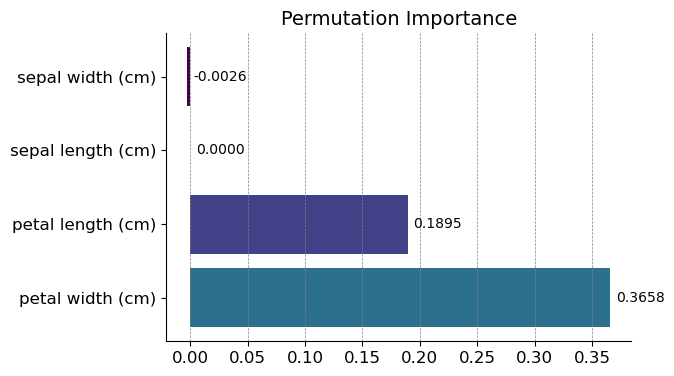

In [113]:
from sklearn.inspection import permutation_importance


perm_importance = permutation_importance(model, X_eval, y_eval, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
color_map = plt.cm.get_cmap('viridis')
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center', color=color_map(perm_importance.importances_mean[sorted_idx]))
plt.yticks(range(len(sorted_idx)), np.array(X_eval.columns)[sorted_idx])
for bar, importance_score in zip(bars, perm_importance.importances_mean[sorted_idx]):
    ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height() / 2, f'{importance_score:.4f}', ha='left', va='center', fontsize=10, color='black')
plt.title('Permutation Importance', fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.xaxis.grid(color='gray', linestyle='--', linewidth=0.5)
ax.invert_yaxis()
plt.show()

### Analysis of permutation importance:

- The Petal Length feature (with the highest positive value) is the most important feature for your model's predictions, and the model relies heavily on it.
- The Petal Width feature (with the second-highest positive value) is also important for the model.
- The rest of the features (with negative values) may not be contributing significantly to the model's performance.

### 3.2. Shap values (implemented in CatBoost library)

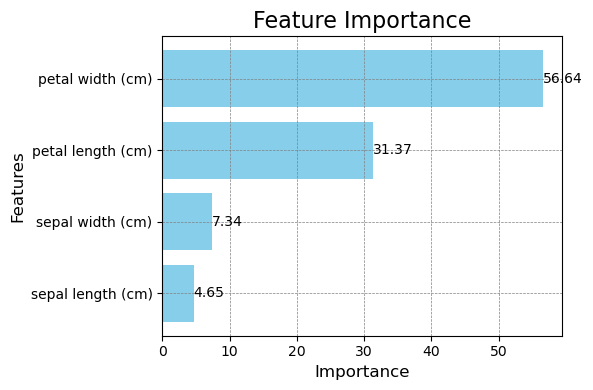

In [114]:
feat_imp_index = list(report_dict['feature_importance'].keys())
feat_imp_vals = list(report_dict['feature_importance'].values())

plt.figure(figsize=(6, 4))

plt.barh(feat_imp_index, feat_imp_vals, color='skyblue')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title("Feature Importance", fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)


for i, v in enumerate(feat_imp_vals):
    plt.text(v, i, f'{v:.2f}', fontsize=10, va='center')

plt.gca().invert_yaxis()
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


### Feature Importances on Shap Values:

* The feature importances represent the global importance of each feature in the model.
* "Petal width (cm)" has the highest importance value, indicating that it is the most influential feature in model's predictions.
* "Petal length (cm)" is the second most important feature, followed by "Sepal width (cm)" and "Sepal length (cm)."

In [151]:
X_tr = X_tr.reset_index().drop(columns=['index'])
X_eval = X_eval.reset_index().drop(columns=['index'])

y_tr = y_tr.reset_index().drop(columns=['index'])
y_eval = y_eval.reset_index().drop(columns=['index'])

### 3.3 Explain predictions with LIME 

In [216]:
from lime.lime_tabular import LimeTabularExplainer
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_eval_encoded = label_encoder.fit_transform(y_eval)
y_tr_encoded = label_encoder.fit_transform(y_tr)

# Create a LIME explainer
lime_explainer = LimeTabularExplainer(X_tr.values, 
                                      mode="classification",
                                      training_labels=y_tr, 
                                      random_state=1234, 
                                      class_names=np.unique(y_eval),
                                      feature_names=X_tr.columns
                                      )

# Choose a specific instance for analysis
instance_idx = 0
instance_to_explain = X_eval.iloc[[instance_idx]]

# Explain the specific instance
explanation = lime_explainer.explain_instance(instance_to_explain.values[0], model.predict_proba, labels=np.unique(y_eval_encoded))

# Visualize the LIME explanation
explanation.show_in_notebook()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


### LIME interpreting results:

For the first instance in dataset the class label is versicolor. Lets analyse this model point and it's predictions

#### For Class 0 (Setosa):

* The feature "petal width (cm)" has a negative impact on the prediction. A decrease in the value of this feature is associated with a lower likelihood of the instance belonging to Class 0 (Setosa).
* The feature "petal length (cm)" also has a negative impact. A decrease in the value of this feature is associated with a lower likelihood of the instance belonging to Class 0 (Setosa).
* The feature "sepal length (cm)" has a negative impact but is less influential. A decrease in the value of this feature is associated with a slightly lower likelihood of the instance belonging to Class 0 (Setosa).
* The feature "sepal width (cm)" has a positive impact. An increase in the value of this feature is associated with a slightly higher likelihood of the instance belonging to Class 0 (Setosa).

#### For Class 1 (Versicolor):

* The feature "petal length (cm)" has a significant negative impact on the prediction. A decrease in the value of this feature is strongly associated with a lower likelihood of the instance belonging to Class 1 (Versicolor).
* The feature "petal width (cm)" also has a substantial negative impact. A decrease in the value of this feature is significantly associated with a lower likelihood of the instance belonging to Class 1 (Versicolor).
* The feature "sepal length (cm)" has a minor positive impact. An increase in the value of this feature is slightly associated with a higher likelihood of the instance belonging to Class 1 (Versicolor).
* The feature "sepal width (cm)" has a negative impact, but it is the least influential among the features listed.

#### For Class 2 (Virginica):

* The feature "petal length (cm)" has a significant positive impact. An increase in the value of this feature is strongly associated with a higher likelihood of the instance belonging to Class 2 (Virginica).
* The feature "petal width (cm)" also has a significant positive impact. An increase in the value of this feature is strongly associated with a higher likelihood of the instance belonging to Class 2 (Virginica).
* The feature "sepal length (cm)" has a minor positive impact. An increase in the value of this feature is slightly associated with a higher likelihood of the instance belonging to Class 2 (Virginica).
* The feature "sepal width (cm)" has a negative impact, but it is the least influential among the features listed.






### Lets look at an example of another class:

In [223]:
instance_idx = 5
instance_to_explain = X_eval.iloc[[instance_idx]]

explanation = lime_explainer.explain_instance(instance_to_explain.values[0], model.predict_proba, labels=np.unique(y_eval_encoded))

explanation.show_in_notebook()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Conclusions for Class Versicolor:

* Versicolor (Class 1) is particularly influenced by the "petal width (cm)" and "petal length (cm)" features. An increase in petal width and a decrease in petal length are strong indicators of an instance being classified as Versicolor.
* Sepal width and sepal length have a relatively minor impact on the prediction for Versicolor. However, an increase in sepal width has a slightly positive influence on the likelihood of the instance being Versicolor.
* These feature contributions align with the characteristics of the Versicolor class in the Iris dataset, indicating that petal measurements are particularly important for distinguishing Versicolor from the other classes.

## 4. Conclusions about data, model and features

1. CatBoost model places significant importance on "Petal Length" and "Petal Width" when making predictions, as evidenced by permutation importance, SHAP values, and LIME explanations.
2. "Sepal Width (cm)" and "Sepal Length (cm)" also contribute to the model's predictions but to a lesser extent.
3. The alignment between permutation importance, SHAP-based importance, and LIME explanations offers confidence in the interpretability and relevance of features in model's decision-making process.